'''
In this version, the catogory 'happy' and 'energetic' are combined.
'''

## Data Processing
### load data

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

# load the data
filename = 'data/all_data.csv'
df = pd.read_csv(filename,index_col=0)
X = df.loc[:,['danceability', 'energy','key','loudness','mode','speechiness',
      'acousticness','instrumentalness','liveness','valence','tempo','duration_ms','time_signature']]
Y = df.iloc[:, -1]

# change the labels with LabelEncoder() and print the mapping relation
label_mapping = {1:'Sad',2:'Healing',4:'joyful'}

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Y = le.fit_transform(Y)

display_labels = [label_mapping[label] for label in le.inverse_transform([0, 1, 2])]
label_mapping_final = [label_mapping[label] for label in le.inverse_transform([0, 1, 2])]
print('Label mapping:',str([0, 1, 2]), '->',label_mapping_final)

Label mapping: [0, 1, 2] -> ['Sad', 'Healing', 'joyful']


### standardization

In [2]:
# standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

### review the data: data shape and class distribution

In [3]:
# data shape
print("The shape (n_samples, n_features) is: ", X_std.shape)

# class distribution
from collections import Counter
counter = Counter(Y)
print(counter)

The shape (n_samples, n_features) is:  (13974, 13)
Counter({1: 9629, 2: 4079, 0: 266})


### review the data: distribution of each feature

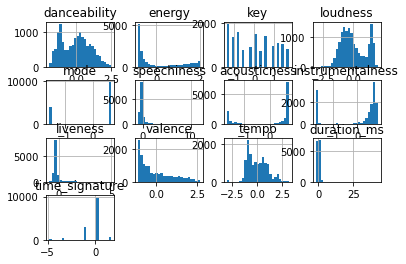

In [4]:
# create a hist plot
X_std.hist(bins=25)
plt.show()

##  SVM

### stratified splitting and SVM

In [5]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X_std,Y,stratify=Y, test_size=0.2, random_state=1)

# train the model on train set
model = SVC()
model.fit(X_train, y_train)

# print prediction results
predictions = model.predict(X_test)
print(classification_report(y_test, predictions, target_names=display_labels))

              precision    recall  f1-score   support

         Sad       0.75      0.06      0.11        53
     Healing       0.93      1.00      0.96      1926
      joyful       0.95      0.84      0.90       816

    accuracy                           0.93      2795
   macro avg       0.88      0.63      0.65      2795
weighted avg       0.93      0.93      0.93      2795



### Attempt1: oversample the data

In [6]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over_sampling_strategy = {0: int(0.3 * len(y_train))}
under_sampling_strategy = {1: int(0.42 * len(y_train)), 2: int(0.28 * len(y_train))}

# define pipeline
over = SMOTE(sampling_strategy=over_sampling_strategy)
under = RandomUnderSampler(sampling_strategy=under_sampling_strategy)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_train, y_train = pipeline.fit_resample(X_train, y_train)
# summarize the new class distribution
counter = Counter(y_train)
print(counter)

Counter({1: 4695, 0: 3353, 2: 3130})


In [7]:
# train the model on train set
model = SVC()
model.fit(X_train, y_train)
  
# print prediction results
predictions = model.predict(X_test)
print(classification_report(y_test, predictions, target_names=display_labels))

              precision    recall  f1-score   support

         Sad       0.18      0.72      0.29        53
     Healing       0.94      0.95      0.94      1926
      joyful       0.98      0.76      0.85       816

    accuracy                           0.89      2795
   macro avg       0.70      0.81      0.70      2795
weighted avg       0.94      0.89      0.91      2795



### Attempt2: grid search for the best hyperparameters

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
param_grid = {'C': [1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01,0.001],
              'kernel': ['rbf']} 
svc_clf = SVC()
scorer = make_scorer(f1_score, average = 'weighted')
grid = GridSearchCV(SVC(), param_grid, scoring=scorer, refit = True)

# fitting the model for grid search
grid.fit(X_train, y_train)

# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=1000, gamma=0.1)


### result

In [9]:
grid_predictions = grid.predict(X_test)
  
# print classification report
print(classification_report(y_test, grid_predictions, target_names=display_labels))

              precision    recall  f1-score   support

         Sad       0.24      0.42      0.31        53
     Healing       0.95      0.95      0.95      1926
      joyful       0.88      0.85      0.87       816

    accuracy                           0.91      2795
   macro avg       0.69      0.74      0.71      2795
weighted avg       0.92      0.91      0.91      2795



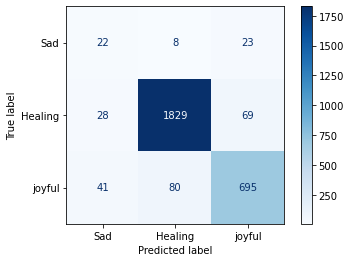

In [10]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

display_labels = [label_mapping[label] for label in le.inverse_transform([0, 1, 2])]
plot_confusion_matrix(grid, X_test, y_test,cmap=plt.cm.Blues, 
                     display_labels=display_labels)  
plt.show() 